In [1]:
# TCC_teste_2
# v.0.7.0
# Author: André Baptista (andrebaptista.com.br)
# Using CNRPark dataset (http://cnrpark.it/)

In [2]:
import numpy as np
import cv2

#help(cv2.HOGDescriptor())

print("OpenCV version: " + cv2.__version__) # mostar versão do openCV

#from google.colab.patches import cv2_imshow     # aparentemente só funciona dentro do ambiente Colab
from matplotlib import pyplot as plt

%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

from os import listdir
from os.path import isfile, join
import os
import os.path
import sys
import pickle

OpenCV version: 4.5.1


In [3]:
input_dir = "C:/TCC_ForaDoOneDrive/CNRPark-Patches-150x150/A/Imagens Selecionadas"

features_dir = "features/"

cluster_dir = "cluster/"

bow_dir = "bow/"

if not os.path.exists(features_dir):
    os.makedirs(features_dir)

if not os.path.exists(cluster_dir):
    os.makedirs(cluster_dir)

if not os.path.exists(bow_dir):
    os.makedirs(bow_dir)

In [4]:
# # limpar diretórios de saída

# # Features (.brief)
# for f in os.listdir(features_dir):
#     if not f.endswith(".brief"):    #if os.path.isdir(f):
#         continue
#     os.remove(os.path.join(features_dir, f))

# # Cluster (cluster.cluster)
# for f in os.listdir(cluster_dir):
#     if not f.endswith(".cluster"):
#         continue
#     os.remove(os.path.join(cluster_dir, f))

# # Bow (.bow)
# for f in os.listdir(bow_dir):
#     if not f.endswith(".bow"):
#         continue
#     os.remove(os.path.join(bow_dir, f))

In [12]:
# Initiate ORB detector
# valores default: ORB(int nfeatures=500, float scaleFactor=1.2f, int nlevels=8, int edgeThreshold=31, int firstLevel=0, int WTA_K=2, int scoreType=ORB::HARRIS_SCORE, int patchSize=31)
orb = cv2.ORB_create(
  nfeatures = 500,                    # The maximum number of features to retain.
  scaleFactor = 1.2,                  # Pyramid decimation ratio, greater than 1
  nlevels = 8,                        # The number of pyramid levels.
  edgeThreshold = 15,                 # This is size of the border where the features are not detected. It should roughly match the patchSize parameter
  firstLevel = 0,                     # It should be 0 in the current implementation.
  WTA_K = 2,                          # The number of points that produce each element of the oriented BRIEF descriptor.
  scoreType = cv2.ORB_HARRIS_SCORE,   # The default HARRIS_SCORE means that Harris algorithm is used to rank features (the score is written to KeyPoint::score and is 
                                      # used to retain best nfeatures features); FAST_SCORE is alternative value of the parameter that produces slightly less stable 
                                      # keypoints, but it is a little faster to compute.
  #scoreType = cv2.ORB_FAST_SCORE,
  patchSize = 15                      # size of the patch used by the oriented BRIEF descriptor. Of course, on smaller pyramid layers the perceived image area covered
                                      # by a feature will be larger.
)

# Initiate BRIEF extractor
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

In [ ]:
%%time

#print(os.path.exists(input_dir))

# leitura das imagens do diretório
onlyfiles = []
if os.path.exists(input_dir):
    onlyfiles = [f for f in listdir(input_dir) if isfile(join(input_dir, f))]
    
    # processa cada arquivo de imagem de um diretório
    for file in onlyfiles:

        print("imagem: " + file)
    
        img_path = join(input_dir, file)

        img = cv2.imread(img_path, 0)

        # mostrar imagem original
        plt.imshow(img)
        plt.show()

        # opcional: redimensiona a imagem
        #img = cv2.resize(
        # img, (160, 160), interpolation=cv2.INTER_CUBIC)
        
        
        
        # Initiate STAR detector
#         star = cv2.xfeatures2d.StarDetector_create()


        # Initiate BRIEF extractor
#         brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
        

        # find the keypoints with STAR
#         kp = star.detect(img, None)

        # find the keypoints with ORB
        kp = orb.detect(img, None)




        # compute the descriptors with BRIEF
#         kp, feat = brief.compute(img, kp)        

        # compute the descriptors with ORB
        kp, feat = orb.compute(img, kp)


        # imprimir numero de features encontradas
        print("número de features (keypoints) encontradas: " + str(len(kp)))
        print("formato (keypoints, dimensões): " + str(np.shape(feat)))
        #print(feat)

        # mostrar imagem com os keypoints encontrados
        img2_kp = cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=cv2.DrawMatchesFlags_DEFAULT)
        plt.figure()
        plt.imshow(img2_kp)
        plt.show()



        feat_path = join(features_dir, file)

        # store the data as binary data stream
        if len(kp) > 0:
            with open(feat_path + ".brief", "wb") as f:
                pickle.dump(feat.tolist(), f)
        else:
            print("Erro: 0 features encontradas")

        # f = open(feat_path + ".brief.txt", "w")
        # f.write(str(feat.tolist()))
        # f.close()

        print("----------------------------------------")

print("Deteção de features (.brief) finalizada")

Criação do vocabulário visual

1. Clusterização

In [14]:
from sklearn.cluster import KMeans
import time

In [15]:
cluster_file = cluster_dir + "cluster.cluster"

In [16]:
# número de clusters
#k = 64
k = 1024

# números de dimensões das features
dim = 32

In [17]:
# salva o vocabulário criado (centroids) em disco
def saveCentroids (kmeans, output_file, dim):
    i = 0
    desc = ""

    for k in np.nditer(kmeans.cluster_centers_):        
        a = np.array(k).round(2)
        desc += str(a) + " "
        i += 1        

        if (i % dim) == 0:
            desc += "\n" 

    output_file.write(desc)

In [18]:
%%time
listOfFeat = []

print(os.path.exists(features_dir))

# leitura das imagens do diretório
onlyfiles = []
if os.path.exists(features_dir):
    onlyfiles = [f for f in listdir(features_dir) if isfile(join(features_dir, f))]
    
    # processa cada arquivo de imagem de um diretório
    for file in onlyfiles:
        #print(file)
    
        feat_path = join(features_dir, file)

        with open(feat_path, 'rb') as f:
            # read the data as binary data stream
            feat = pickle.load(f)

        #print(feat)

        for item in feat:
            listOfFeat.append(item)

output_file = open(cluster_file, 'w')

# print( np.asarray(listOfFeat) )
print( np.asarray(listOfFeat).shape )
# output_file.write(np.asarray(listOfFeat[0]))
    
t1 = time.time()  
kmeans = KMeans(n_clusters=k, random_state=0).fit(np.asarray(listOfFeat))
t2 = time.time()
tf = t2 - t1

print(tf)

saveCentroids (kmeans, output_file, dim)  
output_file.close()

print('Terminado salvar .cluster')

True
(11554, 32)
47.504374265670776
Terminado salvar .cluster
Wall time: 48.2 s


In [19]:
%%time

print('start')

# leitura dos centroids do arquivo
centroids = np.loadtxt(cluster_file)

# obtem o número de centroids (palavras visuais)
clusters = centroids.shape[0]

# leitura das imagens do diretório
onlyfiles = []
if os.path.exists(features_dir):
    onlyfiles = [f for f in listdir(features_dir) if isfile(join(features_dir, f))]

    bowOfImages = []    
    
    # processa cada arquivo de imagem de um diretório
    for file in onlyfiles:
    
        feat_path = join(features_dir, file)

        with open(feat_path, 'rb') as f:
            # read the data as binary data stream
            feat = pickle.load(f)        

        # inicializa o BoW da imagem com zero para cada dimensão
        bow = [0] * clusters

        # procedimento força bruta para cálculo de distância (euclidean distance)
        for item in feat:
            result = sys.float_info.max
            centroid_id = 0

            for id, c in enumerate(centroids):
                # Euclidean Distance 
                dist = np.sqrt(np.sum(np.square(np.subtract(item, c))))
                if dist < result:
                    result = dist
                    centroid_id = id

            bow[centroid_id] += 1                     
        
        bow_path = join(bow_dir, file)

        with open(bow_path + ".bow", 'w') as f:
            for item in bow:
                f.write("%s " % item)

print("Terminado salvar arquivos de bag of words (.bow)")

start
Terminado salvar arquivos de bag of words (.bow)
Wall time: 2min 32s


In [ ]:
Utilizando uma nova imagem qualquer

Calculando features locais da imagem de consulta

In [20]:
path_busca = "C:/TCC_ForaDoOneDrive/CNRPark-Patches-150x150/A/Search/"
q = path_busca + "busy 20150703_0920_14.jpg"
q_feature = q + ".brief"
q_bow = q_feature + ".bow"

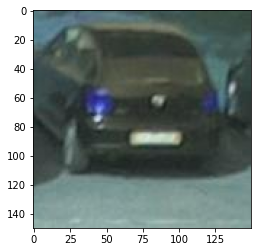

121
(121, 32)


In [21]:
img_search = cv2.imread(q)

#Show the image with matplotlib
plt.imshow(img_search)
plt.show()

# Initiate STAR detector
#star = cv2.xfeatures2d.StarDetector_create()

# Initiate BRIEF extractor
#brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

# find the keypoints with STAR
#kp = star.detect(img_search,None)

# find the keypoints with ORB
kp = orb.detect(img_search, None)

# compute the descriptors with BRIEF
#kp, feat = brief.compute(img_search, kp)        

# compute the descriptors with ORB
kp, feat = orb.compute(img_search, kp)

print(len(kp))
print(np.shape(feat))
# print(feat)

# store the data as binary data stream
with open(q_feature, "wb") as f:
    pickle.dump(feat.tolist(), f)        

In [22]:
# leitura dos centroids do arquivo
centroids = np.loadtxt(cluster_file)

# obtem o número de centroids (palavras visuais)
clusters = centroids.shape[0]

with open(q_feature, 'rb') as f:
    # read the data as binary data stream
    feat = pickle.load(f)        

    # inicializa o BoW da imagem com zero para cada dimensão
    bow = [0] * clusters

    # procedimento força bruta para cálculo de distância (euclidean distance)
    for item in feat:
        result = sys.float_info.max
        centroid_id = 0

        for id, c in enumerate(centroids):
            dist = np.sqrt(np.sum(np.square(np.subtract(item, c))))
            if dist < result:
              result = dist
              centroid_id = id

        bow[centroid_id] += 1                     

    with open(q_bow, 'w') as f:
        for item in bow:
            f.write("%s " % item)

print("Done")

Done


In [23]:
# leitura das imagens do diretório

q = np.loadtxt(q_bow)

onlyfiles = []
if os.path.exists(bow_dir):
    onlyfiles = [f for f in listdir(bow_dir) if isfile(join(bow_dir, f))]

    # processa cada arquivo de imagem de um diretório
    for file in onlyfiles:

        feat_path = join(bow_dir, file)

        item = np.loadtxt(feat_path)

        # print(item)
        # print(item.shape)

        dist = np.sqrt(np.sum(np.square(np.subtract(item, q))))

        print(str(file) + ": " + str(dist))

20150703_0805_18.jpg.brief.bow: 16.46207763315433
20150703_0805_19.jpg.brief.bow: 15.905973720586866
20150703_0805_21.jpg.brief.bow: 15.716233645501712
20150703_0805_26.jpg.brief.bow: 17.635192088548397
20150703_0805_27.jpg.brief.bow: 18.466185312619388
20150703_0805_34.jpg.brief.bow: 22.315913604421397
20150703_0805_38.jpg.brief.bow: 15.968719422671311
20150703_0810_10.jpg.brief.bow: 15.0
20150703_0810_11.jpg.brief.bow: 27.676705006196094
20150703_0810_22.jpg.brief.bow: 16.1245154965971
20150703_0810_36.jpg.brief.bow: 15.748015748023622
20150703_0810_40.jpg.brief.bow: 16.46207763315433
20150703_0810_42.jpg.brief.bow: 14.832396974191326
20150703_0810_46.jpg.brief.bow: 17.832554500127006
20150703_0810_5.jpg.brief.bow: 15.0996688705415
20150703_0825_12.jpg.brief.bow: 28.035691537752374
20150703_0825_20.jpg.brief.bow: 19.519221295943137
20150703_0825_28.jpg.brief.bow: 18.303005217723125
20150703_0825_35.jpg.brief.bow: 15.684387141358123
20150703_0825_42.jpg.brief.bow: 15.524174696260024
2